In [1]:
import sys, os
sys.path.append(os.path.abspath(".."))

import numpy as np
import matplotlib.pyplot as plt

from lib.layers import Dense
from lib.activations import Sigmoid, Tanh
from lib.losses import MSE
from lib.network import Sequential
from lib.optimizer import SGD


# Section 1 — Gradient Checking
This section verifies our backpropagation implementation using numerical approximation.


In [2]:
def numerical_gradient_W(layer, X, y, loss_fn, model, epsilon=1e-5):
    num_grad = np.zeros_like(layer.W)

    # Forward with current weights
    base_out = model.forward(X)
    base_loss = loss_fn.forward(y, base_out)

    for i in range(layer.W.shape[0]):
        for j in range(layer.W.shape[1]):
            # +epsilon
            layer.W[i, j] += epsilon
            loss_plus = loss_fn.forward(y, model.forward(X))

            # -epsilon
            layer.W[i, j] -= 2 * epsilon
            loss_minus = loss_fn.forward(y, model.forward(X))

            # restore
            layer.W[i, j] += epsilon

            num_grad[i, j] = (loss_plus - loss_minus) / (2 * epsilon)

    return num_grad


# Small test network
X = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=float)
y = np.array([[0],[1],[1],[0]], dtype=float)

model = Sequential([
    Dense(2, 4),
    Tanh(),
    Dense(4, 1),
    Sigmoid()
])

loss_fn = MSE()
optimizer = SGD(lr=1.0)

# Forward + backward
out = model.forward(X)
loss = loss_fn.forward(y, out)
grad = loss_fn.backward(y, out)
model.backward(grad)  # compute grads only!

dense0 = model.layers[0]

# Compute gradients
anal_grad_W = dense0.grad_W
num_grad_W = numerical_gradient_W(dense0, X, y, loss_fn, model)

# Compare
difference = np.max(np.abs(anal_grad_W - num_grad_W))
print("Max absolute difference:", difference)


Max absolute difference: 5.629274824059394e-12


# Section 2 — XOR using MSE Loss
Training a small 2-4-1 network to learn XOR logic function.


In [3]:
# XOR Dataset
X = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=float)
y = np.array([[0],[1],[1],[0]], dtype=float)

model = Sequential([
    Dense(2, 4),
    Tanh(),
    Dense(4, 1),
    Sigmoid()
])

loss_fn = MSE()
lr = 1.0
epochs = 50000

loss_history = []

optimizer = SGD(lr=1.0)

for epoch in range(epochs + 1):
    out = model.forward(X)
    loss = loss_fn.forward(y, out)
    loss_history.append(loss)

    grad = loss_fn.backward(y, out)
    model.backward(grad)
    # Update weights using optimizer
    for layer in model.layers:
        if hasattr(layer, "W"):  # only Dense layers
            optimizer.step([layer.W, layer.b], [layer.grad_W, layer.grad_b])

print("Predictions:")
print(model.forward(X))
print("Final Loss:", loss)


Predictions:
[[0.00172285]
 [0.99772406]
 [0.99704908]
 [0.00312659]]
Final Loss: 6.6580513211567085e-06


# Section 3 — Loss Curve
Visualizing convergence during training.


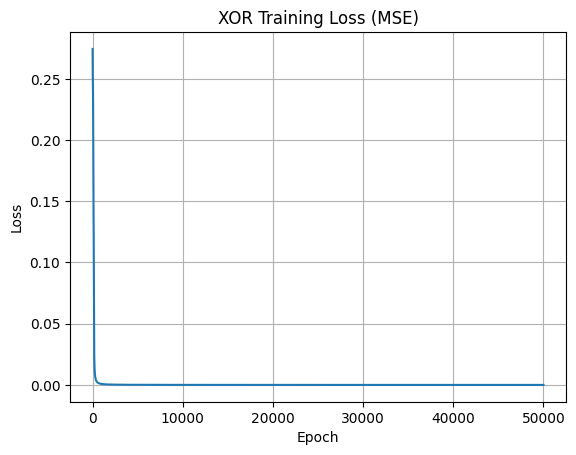

In [4]:
plt.plot(loss_history)
plt.title("XOR Training Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()
